In [2]:
print("strawberry")

strawberry


In [3]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import torch.distributions as td

In [4]:
torch.autograd.set_detect_anomaly(True)

### Set the seed

In [5]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [6]:
is3D = False

In [7]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [8]:
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [9]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [10]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [11]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [12]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8743, 2497, 1248)

In [13]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

### setup model

In [14]:
in_channels = 3
out_channels = 1

if is3D:
    pass
else:
    # encoder_features=[16, 32, 64, 128, 256] # orig: [16, 32, 64, 128, 256]
    # decoder_features=encoder_features[::-1][1:]
    model_raw = HyperMapp3r(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }
                   )
    
    
    optimizer_params={"lr":2e-3}
    lr_scheduler_params={"step_size":20, "gamma":0.1}
    # optimizer_params={"lr":2e-3, "momentum":0.6}
    # optimizer = torch.optim.RMSprop
    # lr_scheduler_params={"milestones":[10,100,200], "gamma":0.5}
    # lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [66]:
### functions for getting code from the evidential distribution. Nice.

def relu_evidence(logits):
    return torch.nn.functional.relu(logits)

def exp_evidence(logits):
    return logits.clamp(-10, 10).exp()

def softplus_evidence(logits):
    return torch.nn.functional.softplus(logits)


def get_S(evidence):
    # evidence is shape [b, c, <dims>], we want an S per pixel, so reduce on dim 1
    S = (evidence + 1.).sum(dim = 1).unsqueeze(1)
    return S

def get_bk(evidence, S):
    return evidence / S

def get_uncert(K, S):
    return K / S

def get_alpha(evidence):
    return (evidence + 1.)**2

def get_one_hot_target(K, target):
    one_hot = torch.zeros((target.shape[0], K, *target.shape[1:])).to(target.device)
    one_hot[:,0] = 1 - target
    one_hot[:,1] = target
    
    return one_hot

def get_mean_p_hat(alpha, S):
    return alpha / S

In [20]:
a = torch.Tensor(torch.randn(3, 2, 3))
b = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])

In [23]:
a

tensor([[[ 2.9827,  0.5370,  2.1760],
         [ 0.3959, -0.1871,  1.1643]],

        [[ 1.1930,  1.0228, -0.2002],
         [-0.5098, -0.4796,  1.1526]],

        [[ 1.4415,  0.3403,  2.0276],
         [-0.2831,  0.5285, -0.2018]]])

In [22]:
a * b.unsqueeze(1)

tensor([[[ 2.9827,  1.0739,  6.5280],
         [ 0.3959, -0.3743,  3.4928]],

        [[ 4.7718,  5.1140, -1.2013],
         [-2.0394, -2.3980,  6.9158]],

        [[10.0906,  2.7223, 18.2486],
         [-1.9818,  4.2283, -1.8166]]])

In [65]:
b.unsqueeze(1) - a

tensor([[[-1.9827,  1.4630,  0.8240],
         [ 0.6041,  2.1871,  1.8357]],

        [[ 2.8070,  3.9772,  6.2002],
         [ 4.5098,  5.4796,  4.8474]],

        [[ 5.5585,  7.6597,  6.9724],
         [ 7.2831,  7.4715,  9.2018]]])

In [141]:
def digamma(values):
    return torch.digamma(values).clamp(-100,100)

def get_alpha_modified(alpha, one_hot_target):
    return one_hot_target + ((1 - one_hot_target) * alpha)

def xent_bayes_risk(alpha, S, one_hot_target):
    digamma_S = torch.digamma(S).expand(alpha.shape)
    digamma_alpha = torch.digamma(alpha)
    
    p_ij = one_hot_target * (digamma_S - digamma_alpha)
    per_pixel_loss =  torch.sum(p_ij, dim=1)
    
    return torch.sum(per_pixel_loss, dim=(-2,-1)).mean() # reduction = mean


def mse_bayes_risk(mean_p_hat, S, one_hot_target):
    l_err = torch.nn.functional.mse_loss(mean_p_hat, one_hot_target, reduction='none')
    
    l_var = mean_p_hat * (1.- mean_p_hat) / (S + 1.)
    
    return (l_err + l_var).sum(dim=(-2,-1)).mean()


class KL_Loss():
    def __init__(self, anneal=True):
        self.counter = 0
        self.anneal = anneal
        
    def __call__(self,alpha_modified):
        self.counter += 1
        #print(self.counter)
        K = alpha_modified.shape[1]
        beta = torch.ones((1, *alpha_modified.shape[1:])).to(alpha_modified.device)
        sum_alpha = alpha_modified.sum(dim=1)
        sum_beta = beta.sum(dim=1)

        lnB = torch.lgamma(sum_alpha) - torch.lgamma(alpha_modified).sum(dim=1)
        lnB_uni = torch.lgamma(beta).sum(dim=1) - torch.lgamma(sum_beta)

        dg0 = torch.digamma(sum_alpha).unsqueeze(1)
        dg1 = torch.digamma(alpha_modified)

        diff = (alpha_modified - beta)
        v = (dg1 - dg0)

        # print(sum_alpha.shape)
        # print(sum_beta.shape)
        # print(diff.shape)
        # print(v.shape)

        rhs = torch.sum(diff * v, dim=1)

        kl = lnB + lnB_uni + rhs

        # the early stopping checks val loss every three epochs. There are about 150
        # batches per train iteration currently, so 150*4, anneal in 4 epochs.
        if self.anneal:
            return torch.sum(kl, dim=(-2,-1)).mean() * (min(1, self.counter/(150*4))**2)
        else:
            return torch.sum(kl, dim=(-2,-1)).mean()
    
KL = KL_Loss()

def dice_bayes_risk(K, alpha, one_hot_target, S):
    bs = alpha.shape[0]
    alpha = alpha.view(bs, K, -1)
    one_hot_target = one_hot_target.view(bs, K, -1)
    S = S.view(bs, 1, -1)
    #print(one_hot_target.shape, alpha.shape, S.shape)
    numerator = torch.sum(one_hot_target * alpha / S, dim=2)
    denominator = torch.sum(one_hot_target ** 2 + (alpha/S)**2 + (alpha*(S-alpha)/((S**2)*(S+1))), dim=2)
    dice= 1 - (2/K) * ((numerator/denominator).sum(dim=1))
    #print(dice.shape)
    return dice.mean()
    
    
def combined_loss(logits, target, kl_obj=KL):
    # get relevent terms required for loss func
    evidence = softplus_evidence(logits)
    S = get_S(evidence)
    alpha = get_alpha(evidence)
    K = alpha.shape[1]
    one_hot = get_one_hot_target(K, target)
    mean_p_hat = get_mean_p_hat(alpha, S)
    alpha_modified = get_alpha_modified(alpha, one_hot)
    
    
    #mse = mse_bayes_risk(mean_p_hat, S, one_hot)
    #xent = xent_bayes_risk(alpha, S, one_hot)
    dice = dice_bayes_risk(K, alpha, one_hot, S)
    kl = kl_obj(alpha_modified)
    
    #dice = dice_loss(mean_p_hat, target)
    
    # print(kl)
    # print(xent)
    #print(dice)
    # print("--")
    
    return dice + 0.1 * kl

In [142]:
#summary(model_raw, (1, 3, 128, 128))

In [143]:
loss = combined_loss
# loss = soft_dice

In [144]:
optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [145]:
import torch.nn.functional as F
class EvidLitModelWrapper(pl.LightningModule):
        def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                    optimizer_constructor=None, lr_scheduler_constructor=None):
            super().__init__()
            self.model = model
            self.loss = loss
            self.logging_metric_train = logging_metric()
            self.logging_metric_val = logging_metric()
            self.optim_params = optimizer_params
            self.lr_scheduler_params = lr_scheduler_params
            self.is_uq_model = False
            self.optimizer_constructor = optimizer_constructor
            self.lr_scheduler_constructor = lr_scheduler_constructor


        def forward(self, x, **kwargs):
            return self.model(x, **kwargs)

        def configure_optimizers(self):
            # optimizer and schedulers go in the configure optimizers hook
            if self.optimizer_constructor:
                optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
            else:
                optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)

            if self.lr_scheduler_constructor:
                lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
            else:
                lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)

            return [optimizer], [lr_scheduler]

        def training_step(self, batch, batch_idx):
            """
            lightning automates the training loop, 
            does epoch, back_tracking, optimizers and schedulers,
            and metric reduction.
            we just define how we want to process a single batch. 
            we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
            hook, and I presume we can add our own parameters also to functions?
            """

            if self.is_uq_model:
                self.model.set_applyfunc(True)

            X, y = batch
            y_hat = self(X)
            #print(batch_idx)
            loss = self.loss(y_hat, y)

            # metrics 
            if self.logging_metric_train:
                self.logging_metric_train(y_hat, y)
                self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
            self.log("train_loss", loss)

            return loss

    #     def training_epoch_end(self, outs):
    #         self.log('train_metric_epoch', self.logging_metric_train.compute())

    #     def validation_epoch_end(self, outs):
    #         self.log('val_metric_epoch', self.logging_metric_val.compute())

        def validation_step(self, batch, batch_idx):
            """
            note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
            well yes I want to enable checkpointing but will deal with that later.
            also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
            I will need a custom eval thing to do my dropout estimation but can solve that later too.
            """
            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            val_loss = self.loss(y_hat, y)

            if self.logging_metric_val:
                self.logging_metric_val(y_hat, y)
                self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
            self.log("val_loss", val_loss)

        def test_step(self, batch, batch_idx):
            """
            we would need to directly call this function using the trainer
            """

            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            test_loss = self.loss(y_hat, y)
            self.log("test_loss", test_loss)

        def predict_step(self, batch, batch_idx):
            """
            just for making predictions as opposed to collecting metrics etc
            note to use this, we just call .predict(dataloader) and it then automates the look
            these functions are for a single batch. Nice.
            """
            X, y = batch
            pred = self(X)
            return pred

In [158]:
# metric that calcualtes the kl fully annealled, for early stopping
from torchmetrics import Metric
class FullKLEvidMetric(Metric):
    is_differentiable = False
    higher_is_better = True
    full_state_update = False
    def __init__(self):
        super().__init__()
        self.add_state("value", default=torch.tensor(0, dtype=torch.float32), dist_reduce_fx=None)
        self.kl_obj = KL_Loss(anneal=False)

    def update(self, preds: torch.Tensor, target: torch.Tensor):

        self.value =  combined_loss(preds, target, self.kl_obj)

    def compute(self):
        return self.value

In [159]:
model = EvidLitModelWrapper(model_raw, loss, 
                                logging_metric=FullKLEvidMetric,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )
# checkpoint="../epoch=38-step=1560.ckpt"
# model = StandardLitModelWrapper.load_from_checkpoint(checkpoint, model=model_raw, loss=loss, logging_metric=DiceLossMetric)

In [160]:
# x1, y1 = next(iter(train_dataloader))
# with torch.no_grad():
#     pred = model(x1.to(model.device))

In [161]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

#checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_metric", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True, strict=True)
trainer = pl.Trainer(
    callbacks=[early_stop_callback], # callbacks=[checkpoint_callback, early_stop_callback]
    check_val_every_n_epoch=1,
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### train

In [164]:
trainer.fit(model, train_dataloader, val_dataloader)

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory lightning_logs/lightning_logs/version_7/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type             | Params
----------------------------------------------------------
0 | model                | HyperMapp3r      | 2.8 M 
1 | logging_metric_train | FullKLEvidMetric | 0     
2 | logging_metric_val   | FullKLEvidMetric | 0     
----------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.098    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 3it [00:00, ?it/s]

Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Exception ignored in: Exception ignored in: <function tqdm.__del__ at 0x7fb0878bbca0><function tqdm.__del__ at 0x7fb0878bbca0>

Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
        self.close()self.close()
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/tqdm/notebook.py", line 283, in close

  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/tqdm/notebook.py", line 283, in close
        super(tqdm_notebook, self).close()super(tqdm_notebook, self).close()
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/tqdm/std.py", line 1289, in close

  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/tqdm/std.py", line 1289, in close
    self._decr_instances(self)
  File "/home/s2208943/

In [165]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.5034120678901672
    val_metric_epoch        0.5068884491920471
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.5068884491920471, 'val_loss': 0.5034120678901672}]

In [64]:
#model.model.load_state_dict(torch.load("unwrapped_eddomain_trustable.ckpt"))

In [27]:
def epistemic_uncert(K, S):
    return K / S

def aleotoric_uncert(alpha, S):
    lhs = torch.digamma(alpha + 1)
    rhs = torch.digamma(S + 1)
    
    frac = alpha / S
    
    return -torch.sum(frac * (lhs - rhs), dim=1)
    
    
def distributional_uncert(alpha, S):
    frac = alpha / S
    rhs = torch.log(frac) - torch.digamma(alpha + 1) + torch.digamma(S + 1)
    return -torch.sum(frac * rhs, dim=1)

In [48]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             939.930908203125
    val_metric_epoch        0.2895929217338562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.2895929217338562, 'val_loss': 939.930908203125}]

In [26]:
#torch.save(model.model.state_dict(), "unwrapped_eddomain_trustable2.ckpt")

In [49]:
def actual_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    # count how many times the ground truth and target have nothing in them
    s0 = y_hat.shape[0]
    y_hat = y_hat.view(s0, -1)
    y_true = y_true.view(s0, -1)
    # print(torch.sum(torch.sum(y_true, dim=1) == 0))
    # print(torch.sum(torch.sum(y_hat, dim=1) == 0))
    # print(torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0)))
    ignores = torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0))
    
    
    numerator = torch.sum(2 * y_true * y_hat, dim=1)
    # print(numerator)
    denominator = torch.sum(y_true + y_hat, dim=1)
    # print(denominator)
    
    return torch.sum((numerator)/ (denominator + 1e-8)) / (s0-ignores) # s0

In [50]:
def slice_dice(y_hat, y_true):
    # print(y_hat.shape)
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    # print(y_hat.shape)
    # print(y_true.shape)
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [51]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [52]:
with torch.no_grad():
    x1, y1 = next(iter(val_dataloader))
    logits = model(x1)

evidence = softplus_evidence(logits)
S = get_S(evidence)
alpha = get_alpha(evidence)
K = alpha.shape[1]
one_hot = get_one_hot_target(K, y1)
mean_p_hat = get_mean_p_hat(alpha, S)
alpha_modified = get_alpha_modified(alpha, one_hot)
eus = epistemic_uncert(K, S)
aus = aleotoric_uncert(alpha, S)
dus = distributional_uncert(alpha, S)

In [53]:
model_copy = HyperMapp3r(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }
                   )
model_2 = StandardLitModelWrapper.load_from_checkpoint(checkpoint, model=model_copy, loss=loss, logging_metric=DiceLossMetric)
model_2.model.load_state_dict(torch.load("unwrapped_eddomain_trustable.ckpt"))

<All keys matched successfully>

In [54]:
summary(model_2)

Layer (type:depth-idx)                        Param #
StandardLitModelWrapper                       --
├─HyperMapp3r: 1-1                            --
│    └─ModuleList: 2-1                        --
│    │    └─HM3Block: 3-1                     4,608
│    │    └─HM3Block: 3-2                     18,432
│    │    └─HM3Block: 3-3                     73,728
│    │    └─HM3Block: 3-4                     294,912
│    │    └─HM3Block: 3-5                     1,179,648
│    └─ModuleList: 2-2                        --
│    │    └─Conv2d: 3-6                       448
│    │    └─Conv2d: 3-7                       4,640
│    │    └─Conv2d: 3-8                       18,496
│    │    └─Conv2d: 3-9                       73,856
│    │    └─Conv2d: 3-10                      295,168
│    └─ModuleList: 2-3                        --
│    │    └─HMFeatureBlock: 3-11              311,552
│    │    └─HMFeatureBlock: 3-12              77,952
│    │    └─HMFeatureBlock: 3-13              19,520
│    └─Modu

In [55]:
model_2.model.encoder_resuq_blocks[0].conv1

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)

In [56]:
model

StandardLitModelWrapper(
  (model): StandardLitModelWrapper(
    (model): StandardLitModelWrapper(
      (model): StandardLitModelWrapper(
        (model): HyperMapp3r(
          (encoder_resuq_blocks): ModuleList(
            (0): HM3Block(
              (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
              (dropout1): Dropout2d(p=0.5, inplace=False)
              (norm1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
              (norm2): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
            )
            (1): HM3Block(
              (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
              (dropou

In [75]:
#module = model_2.model.final_a
module = model_2.model.encoder_resuq_blocks[0].conv1
torch.nn.init.xavier_uniform_(module.weight)
pass

In [76]:
torch.where(y1.sum(dim=(1,2)) > 0)

(tensor([ 0,  1,  3,  5,  6, 10, 11, 12, 14, 15, 18, 20, 21, 23, 26, 28, 29, 30]),)

In [77]:
with torch.no_grad():
    logits = model_2(x1)

evidence = softplus_evidence(logits)
S = get_S(evidence)
alpha = get_alpha(evidence)
K = alpha.shape[1]
one_hot = get_one_hot_target(K, y1)
mean_p_hat = get_mean_p_hat(alpha, S)
alpha_modified = get_alpha_modified(alpha, one_hot)
eus = epistemic_uncert(K, S)
aus = aleotoric_uncert(alpha, S)
dus = distributional_uncert(alpha, S)

In [78]:
def runplot():
    plt.figure(figsize=(30, 10))
    inds = [ 0,  1,  3,  5,  6, 10, 11, 12, 14, 15, 18, 20, 21, 23, 26, 28, 29, 30]
    for i in range(len(inds)):
        plt.subplot(3, 9, i+1)
        plt.imshow(eus[i].squeeze())
        plt.axis('off')

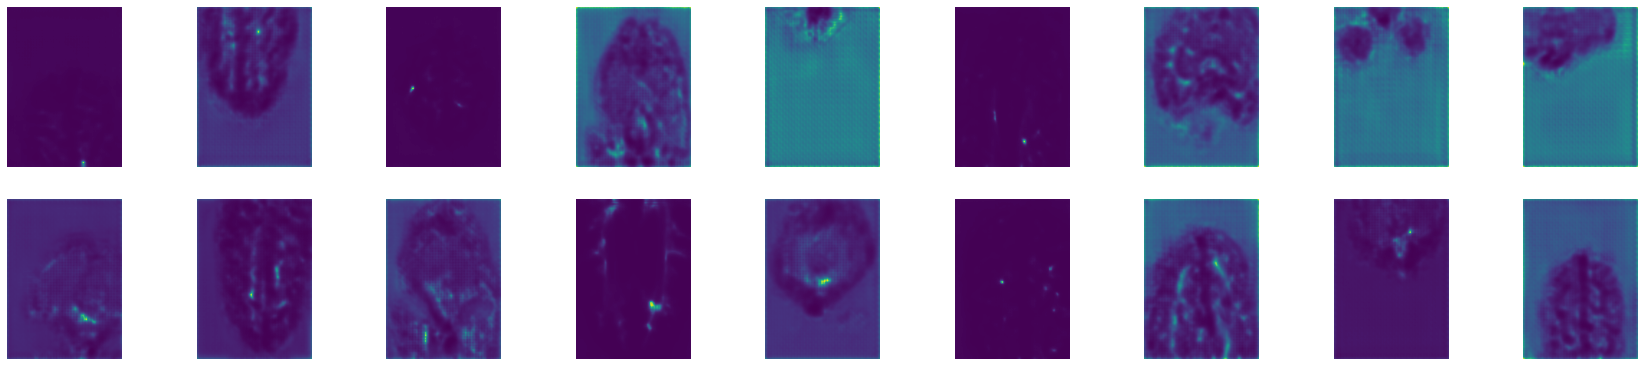

In [79]:
runplot()

In [ ]:
# going from the last layer back (see from the previous image)

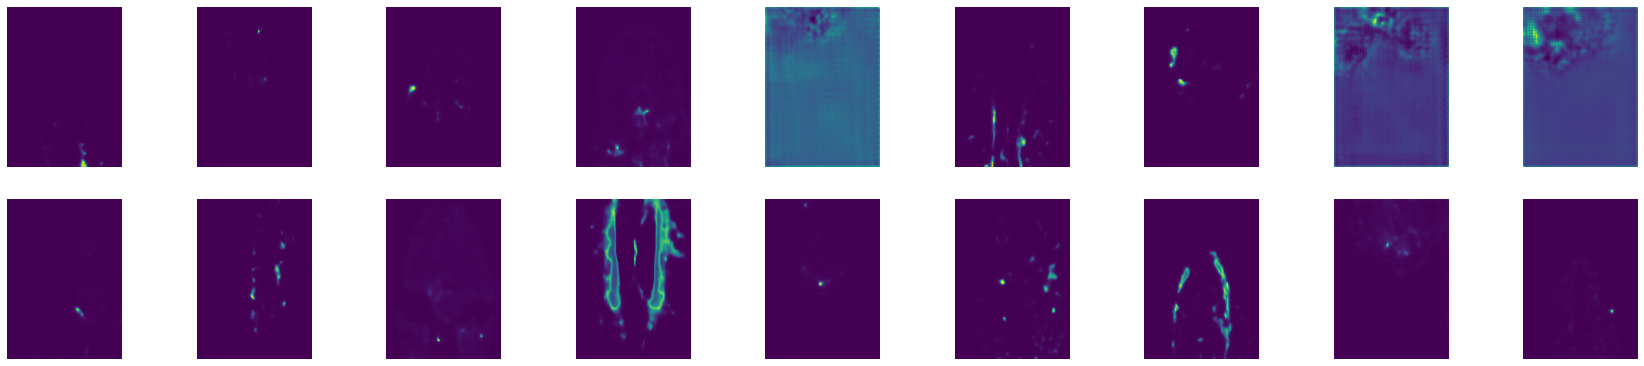

In [69]:
runplot()

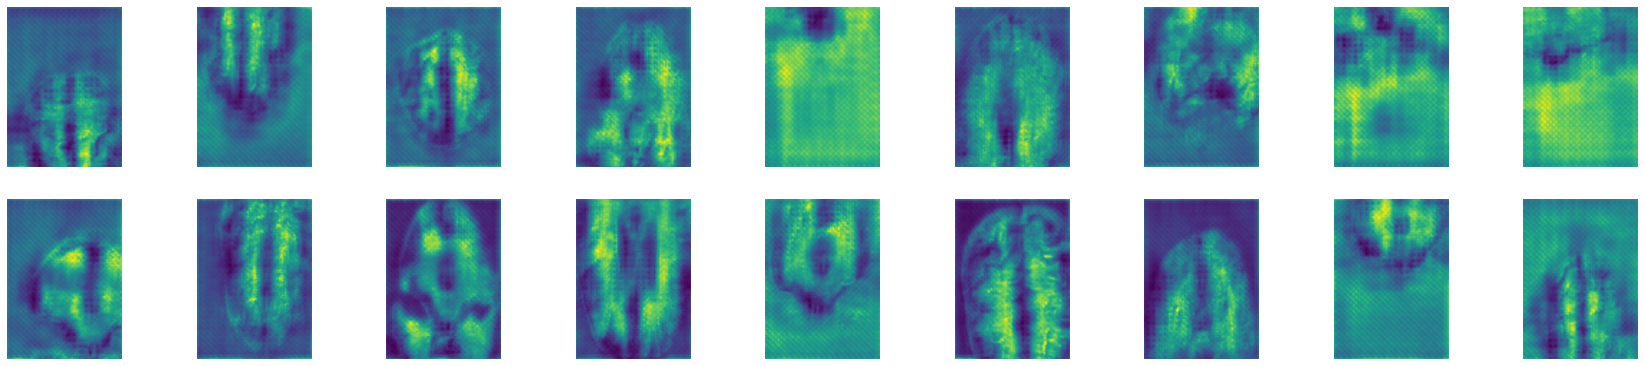

In [65]:
runplot()

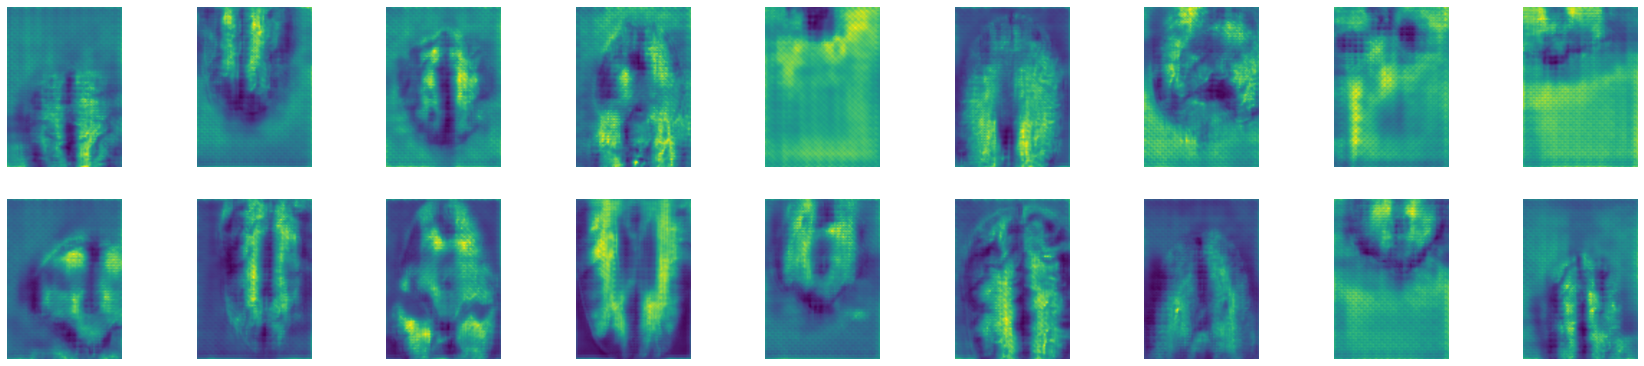

In [58]:
runplot()

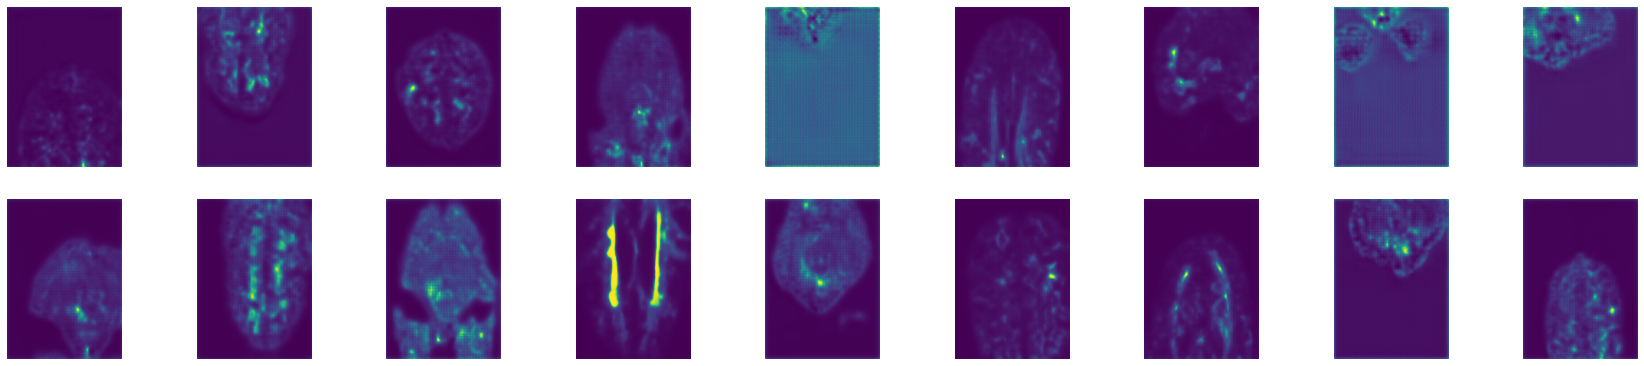

In [55]:
runplot()

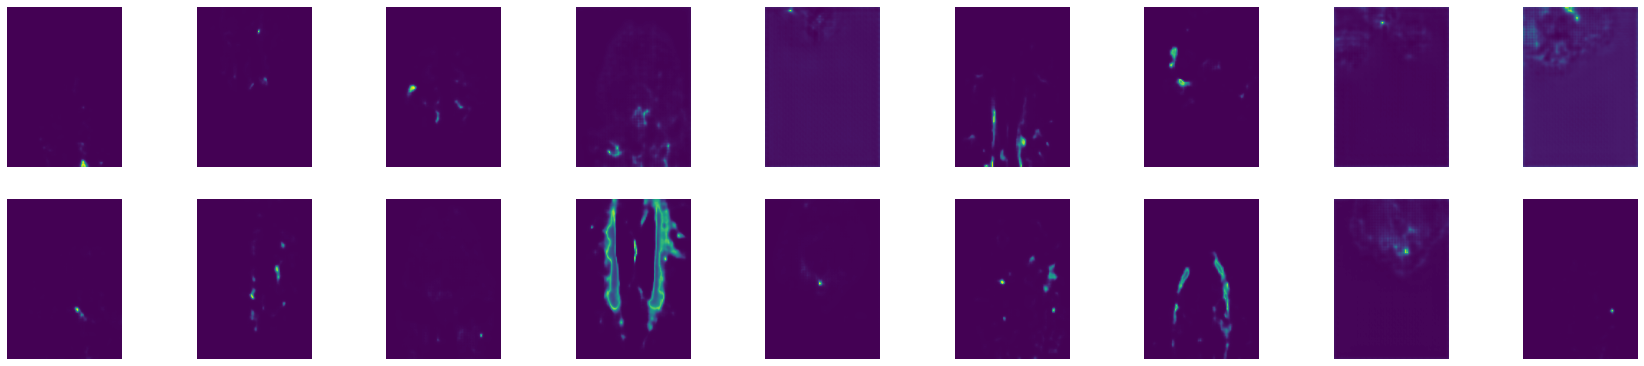

In [39]:
plt.figure(figsize=(30, 10))
inds = [ 0,  1,  3,  5,  6, 10, 11, 12, 14, 15, 18, 20, 21, 23, 26, 28, 29, 30]
for i in range(len(inds)):
    plt.subplot(3, 9, i+1)
    plt.imshow(eus[i].squeeze())
    plt.axis('off')
        

tensor(0.4009)


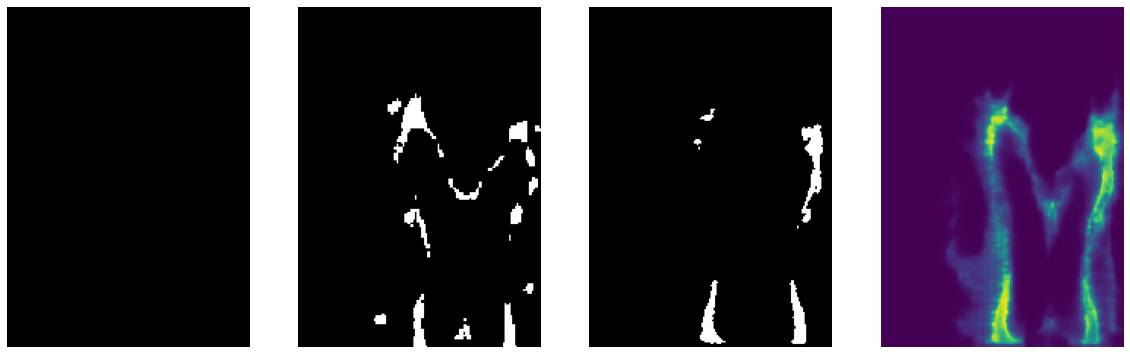

In [31]:
ind = 20
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind],cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(mean_p_hat.argmax(dim=1)[ind],cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(eus[ind].squeeze())
print(slice_dice(mean_p_hat[ind], y1[ind])); plt.axis('off')
plt.show()

In [32]:
z = torch.Tensor([[1,2,3,4], [2,3,4,5], [4,5,6,7], [7,8,9,10]])

In [33]:
z

tensor([[ 1.,  2.,  3.,  4.],
        [ 2.,  3.,  4.,  5.],
        [ 4.,  5.,  6.,  7.],
        [ 7.,  8.,  9., 10.]])

In [34]:
torch.linalg.matrix_rank(z)

tensor(2)

In [35]:
inv = torch.linalg.inv(z)

In [36]:
torch.linalg.matrix_rank(inv)

tensor(2)

## Training the model to minimise uncertianty on the new domain test data

In [37]:
domains_all = [
            wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ]

In [38]:
domains_all

['/disk/scratch/s2208943/ipdis/preprep/out_data/collated/WMH_challenge_dataset/Singapore',
 '/disk/scratch/s2208943/ipdis/preprep/out_data/collated/WMH_challenge_dataset/Utrecht',
 '/disk/scratch/s2208943/ipdis/preprep/out_data/collated/WMH_challenge_dataset/GE3T']

In [39]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains_all = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains_all]
else:
    datasets_domains_all = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains_all]

# split into train, val test datasets
datasets_alldm = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains_all]

# concat the train val test datsets
all_dataloaders_train = [DataLoader(ds[0], batch_size=32, shuffle=True, num_workers=4) for ds in datasets_alldm]

In [40]:
all_dataloaders_val = [DataLoader(ds[1], batch_size=32, shuffle=True, num_workers=4) for ds in datasets_alldm]
all_dataloaders_test = [DataLoader(ds[2], batch_size=32, shuffle=True, num_workers=4) for ds in datasets_alldm]

In [41]:
for i in range(len(all_dataloaders_train)):
    print("domain: ", domains_all[i])
    trainer.validate(model, all_dataloaders_train[i])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


domain:  /disk/scratch/s2208943/ipdis/preprep/out_data/collated/WMH_challenge_dataset/Singapore


/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:487: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss               438.205078125
    val_metric_epoch        0.3107841908931732
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
domain:  /disk/scratch/s2208943/ipdis/preprep/out_data/collated/WMH_challenge_dataset/Utrecht


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             646.773193359375
    val_metric_epoch        0.39889293909072876
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
domain:  /disk/scratch/s2208943/ipdis/preprep/out_data/collated/WMH_challenge_dataset/GE3T


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss              169.33837890625
    val_metric_epoch        0.14098262786865234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [42]:
evidence.max()

tensor(7429.2422)

In [43]:
mean_p_hat.max()

tensor(0.9999)

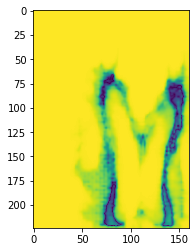

In [48]:
# the max is always larger for the background, so 
plt.imshow(mean_p_hat.max(dim=1)[0][ind])

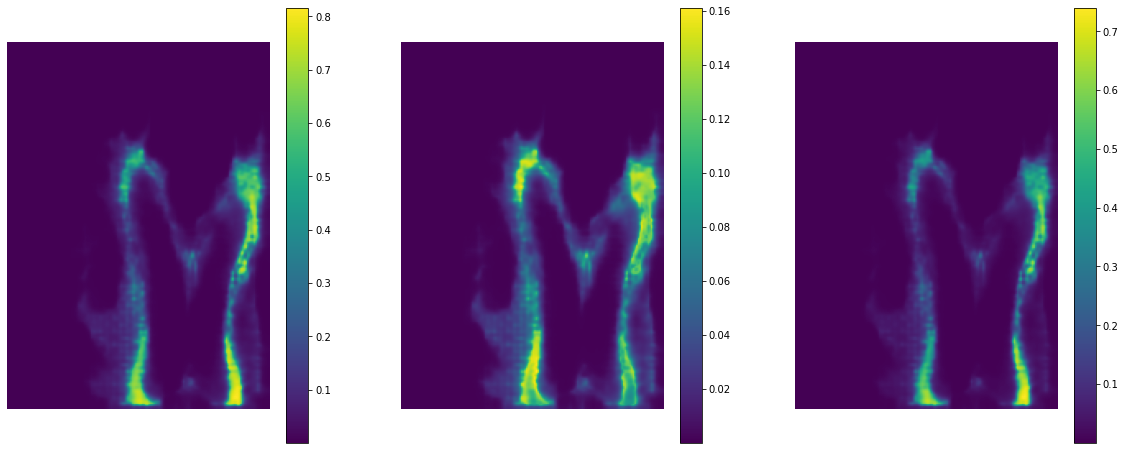

In [44]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.imshow(mean_p_hat[ind][1]); plt.axis('off'); plt.colorbar();
plt.subplot(1, 3, 2)
plt.imshow(dus[ind].squeeze()); plt.axis('off'); plt.colorbar();
plt.subplot(1, 3, 3)
plt.imshow((mean_p_hat[ind][1] - dus[ind].squeeze())); plt.axis('off'); plt.colorbar();

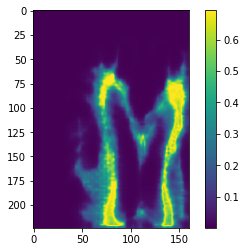

In [45]:
plt.imshow(torch.sum(-mean_p_hat * torch.log(mean_p_hat), dim=1)[ind]); plt.colorbar()

In [146]:
model_fixed = HyperMapp3r(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }
                   )

model_fixed.load_state_dict(torch.load("unwrapped_eddomain_trustable.ckpt"))
model_fixed = model_fixed.cuda()

In [157]:
model_mod = HyperMapp3r(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }
                   )

model_mod.load_state_dict(torch.load("unwrapped_eddomain_trustable.ckpt"))
model_mod = model_mod.cuda()

In [169]:
def confidences(logits):
    evidence = softplus_evidence(logits)
    S = get_S(evidence)
    alpha = get_alpha(evidence)
    K = alpha.shape[1]
    #one_hot = get_one_hot_target(K, y1)
    mean_p_hat = get_mean_p_hat(alpha, S)
    #alpha_modified = get_alpha_modified(alpha, one_hot)
    # eus = epistemic_uncert(K, S)
    # aus = aleotoric_uncert(alpha, S)
    dus = distributional_uncert(alpha, S)
    
    return mean_p_hat, dus


def two_class_prob(p_hat):
    p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_hat = p_hat[:,1,:] # select class 0
    return p_hat

def individual_dice(p_hat, y_true):
    p_hat = two_class_prob(p_hat)
    s0 = p_hat.shape[0]
    p_hat = p_hat.view(s0,-1)
    y_true = y_true.view(s0,-1)
    numerator = torch.sum(2. * p_hat * y_true, dim=1) + 1.
    denominator = torch.sum(y_true + p_hat, dim=1) + 1.
    combined = 1. - (numerator/denominator)
    return combined

def reduce_uncertainty_loss(logits, orig_logits):
    p_hat, dus = confidences(logits)
    orig_p_hat, _ = confidences(orig_logits)
    
    uncert_loss = torch.sum(dus, dim=(-2, -1)).mean()
   
    ent = torch.sum(-p_hat * torch.log(p_hat), dim=1)
    ent_loss = ent.sum(dim=(-2, -1)).mean()
    
    orig_labels = orig_p_hat.argmax(dim=1)
    mean_orig_c1_conf = orig_p_hat[:,1][torch.where(orig_labels)[0]].mean(dim=1).mean()
    
    mean_confs = []
    for i in range(orig_p_hat.shape[0]):
        c1_conf = mean_p_hat[i, 1].view(-1)
        wheres = torch.where(mean_p_hat[i].argmax(dim=0).view(-1))
        if len(wheres[0]) == 0:
            mean_confs.append(0)
            continue
        mean_conf = c1_conf[wheres[0]].mean()
        mean_confs.append(mean_conf.cpu().item())
        
    conf_map_c1 = p_hat[:,1]
        
    consistency_loss = combined_weighted_loss(logits, orig_labels, conf_map_c1, mean_confs)
    
    print(uncert_loss)
    print(ent_loss)
    print(consistency_loss)
    
    return consistency_loss * 0.01 + uncert_loss + ent_loss
        

def xent_bayes_risk_conf(alpha, S, one_hot_target, conf_map):
    digamma_S = torch.digamma(S).expand(alpha.shape)
    digamma_alpha = torch.digamma(alpha)
    
    p_ij = one_hot_target * (digamma_S - digamma_alpha)
    per_pixel_loss =  torch.sum(p_ij, dim=1) * conf_map
    
    return (torch.sum(per_pixel_loss, dim=(-2,-1))).mean() # reduction = mean


def KL_conf(alpha_modified, conf_map):
    K = alpha_modified.shape[1]
    beta = torch.ones((1, *alpha_modified.shape[1:])).to(alpha_modified.device)
    sum_alpha = alpha_modified.sum(dim=1)
    sum_beta = beta.sum(dim=1)
    
    lnB = torch.lgamma(sum_alpha) - torch.lgamma(alpha_modified).sum(dim=1)
    lnB_uni = torch.lgamma(beta).sum(dim=1) - torch.lgamma(sum_beta)
    
    dg0 = torch.digamma(sum_alpha).unsqueeze(1)
    dg1 = torch.digamma(alpha_modified)
    
    diff = (alpha_modified - beta)
    v = (dg1 - dg0)
    
    # print(sum_alpha.shape)
    # print(sum_beta.shape)
    # print(diff.shape)
    # print(v.shape)
    
    rhs = torch.sum(diff * v, dim=1)
    
    kl = lnB + lnB_uni + rhs
    
    return (torch.sum(kl * conf_map, dim=(-2,-1))).mean()
                                
                                
def combined_weighted_loss(logits, target, conf_map, mean_confs):
    # get relevent terms required for loss func
    evidence = softplus_evidence(logits)
    S = get_S(evidence)
    alpha = get_alpha(evidence)
    K = alpha.shape[1]
    one_hot = get_one_hot_target(K, target)
    mean_p_hat = get_mean_p_hat(alpha, S)
    alpha_modified = get_alpha_modified(alpha, one_hot)
    
    
    #mse = mse_bayes_risk(mean_p_hat, S, one_hot)
    xent = xent_bayes_risk_conf(alpha, S, one_hot, conf_map)
    kl = KL_conf(alpha_modified, conf_map)
    
    dice = individual_dice(mean_p_hat, target)
    dice = dice * torch.Tensor(mean_confs).to(dice.device)
    dice = dice.mean()
    
    # print(kl)
    # print(xent)
    # print(dice)
    # print("--")
    
    return xent + kl * 0.2 + dice

In [170]:
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F


def confidences(logits):
    evidence = softplus_evidence(logits)
    S = get_S(evidence)
    alpha = get_alpha(evidence)
    K = alpha.shape[1]
    #one_hot = get_one_hot_target(K, y1)
    mean_p_hat = get_mean_p_hat(alpha, S)
    #alpha_modified = get_alpha_modified(alpha, one_hot)
    # eus = epistemic_uncert(K, S)
    # aus = aleotoric_uncert(alpha, S)
    dus = distributional_uncert(alpha, S)
    
    return mean_p_hat, dus

class ReductionModelWrapper(pl.LightningModule):
    def __init__(self, model, loss=F.cross_entropy, initial_batches = 300, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                optimizer_constructor=None, lr_scheduler_constructor=None):
        super().__init__()
        self.model = model
        self.loss = loss
        self.logging_metric_train = logging_metric()
        self.logging_metric_val = logging_metric()
        self.optim_params = optimizer_params
        self.lr_scheduler_params = lr_scheduler_params
        self.optimizer_constructor = optimizer_constructor
        self.lr_scheduler_constructor = lr_scheduler_constructor
        self.num_annotations = 5
        
    def forward(self, x, y, fixed_runs = None, diagnostic=False, **kwargs):
        # TODO: rewrite this section!!!
        # measure the performance when we modify boundaries etc. Try just giving the model the input with the
        # labels generated by the uncertinaty map?
        with torch.no_grad():
            model_fixed.eval()
            orig_pred = model_fixed(x)
            
        y_hat = self.model(x)
        return y_hat, orig_pred
        
            
       
    
    def configure_optimizers(self):
        # optimizer and schedulers go in the configure optimizers hook
        if self.optimizer_constructor:
            optimizer = self.optimizer_constructor(self.model.parameters(), **self.optim_params)
        else:
            optimizer = torch.optim.Adam(self.model.parameters(), **self.optim_params)
        
        if self.lr_scheduler_constructor:
            lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
        else:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)
        
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        """
        lightning automates the training loop, 
        does epoch, back_tracking, optimizers and schedulers,
        and metric reduction.
        we just define how we want to process a single batch. 
        we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
        hook, and I presume we can add our own parameters also to functions?
        """
        
        X, y = batch
        y_hat, orig_y_hat = self(X, y)
        loss = self.loss(y_hat, orig_y_hat)
        
        # metrics 
        if self.logging_metric_train:
            self.logging_metric_train(y_hat, y)
            self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        """
        note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
        well yes I want to enable checkpointing but will deal with that later.
        also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
        I will need a custom eval thing to do my dropout estimation but can solve that later too.
        """
        
        X, y = batch
        y_hat, orig_y_hat = self(X, y)
        val_loss = self.loss(y_hat, orig_y_hat)
        
        if self.logging_metric_val:
            self.logging_metric_val(y_hat, y)
            self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_loss", val_loss)
        
    def test_step(self, batch, batch_idx):
        """
        we would need to directly call this function using the trainer
        """
        
        X, y = batch
        y_hat = self(X, y, fixed_runs=3)
        test_loss = self.loss(y_hat, y)
        self.log("test_loss", test_loss)
        
    def predict_step(self, batch, batch_idx):
        """
        just for making predictions as opposed to collecting metrics etc
        note to use this, we just call .predict(dataloader) and it then automates the look
        these functions are for a single batch. Nice.
        """
        X, y = batch
        pred = self(X)
        return pred

In [171]:
reduction_model = ReductionModelWrapper(model_mod, reduce_uncertainty_loss, 
                                logging_metric=DiceLossMetric,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

In [172]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

#checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[early_stop_callback], # callbacks=[checkpoint_callback, early_stop_callback]
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [173]:
trainer.validate(reduction_model, all_dataloaders_val[1])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

tensor(56.0205, device='cuda:0')
tensor(580.1995, device='cuda:0')
tensor(93.0559, device='cuda:0')
tensor(46.4865, device='cuda:0')
tensor(540.5902, device='cuda:0')
tensor(83.5259, device='cuda:0')
tensor(54.5395, device='cuda:0')
tensor(580.6177, device='cuda:0')
tensor(86.2029, device='cuda:0')
tensor(56.9123, device='cuda:0')
tensor(663.3212, device='cuda:0')
tensor(113.4581, device='cuda:0')
tensor(65.6388, device='cuda:0')
tensor(659.0383, device='cuda:0')
tensor(117.0626, device='cuda:0')
tensor(73.4093, device='cuda:0')
tensor(783.5716, device='cuda:0')
tensor(154.4909, device='cuda:0')
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             694.4705200195312
    val_metric_epoch        0.3458424508571625
─────────────────

[{'val_metric_epoch': 0.3458424508571625, 'val_loss': 694.4705200195312}]

In [174]:
trainer.fit(reduction_model, all_dataloaders_train[1], all_dataloaders_val[1])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type           | Params
--------------------------------------------------------
0 | model                | HyperMapp3r    | 2.8 M 
1 | logging_metric_train | DiceLossMetric | 0     
2 | logging_metric_val   | DiceLossMetric | 0     
--------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.098    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

tensor(70.8349, device='cuda:0')
tensor(695.3184, device='cuda:0')
tensor(121.5787, device='cuda:0')
tensor(62.8870, device='cuda:0')
tensor(644.7229, device='cuda:0')
tensor(98.4402, device='cuda:0')


Training: 0it [00:00, ?it/s]

tensor(51.9151, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(583.0043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(81.2072, device='cuda:0', grad_fn=<AddBackward0>)
tensor(46.7695, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(554.2565, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(174.4821, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.6703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(273.0449, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(56.3014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.9976, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(200.7951, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(19.4615, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.1641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(193.2122, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.4611, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.0596, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(178.3988, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.9971

Validation: 0it [00:00, ?it/s]

In [130]:
reduction_model = reduction_model.cuda()

In [131]:
with torch.no_grad():
    x1, y1 = next(iter(val_dataloader))
    x1=x1.to(reduction_model.device)
    y1 = y1.to(reduction_model.device)
    logits, _ = reduction_model(x1, y1)
    logits_orig = model_fixed(x1).cpu()
    logits = logits.cpu()
    x1 = x1.cpu()
    y1 = y1.cpu()

evidence = softplus_evidence(logits)
S = get_S(evidence)
alpha = get_alpha(evidence)
K = alpha.shape[1]
one_hot = get_one_hot_target(K, y1)
mean_p_hat = get_mean_p_hat(alpha, S)
alpha_modified = get_alpha_modified(alpha, one_hot)
eus = epistemic_uncert(K, S)
aus = aleotoric_uncert(alpha, S)
dus = distributional_uncert(alpha, S)

In [149]:
with torch.no_grad():
    #model_fixed.eval()
    print((model_fixed(x1.cuda()).cpu() - model_fixed(x1.cuda()).cpu()).mean())

tensor(-1.3846e-06)


In [140]:
logits - logits_orig

tensor([[[[-3.5821e+00, -3.8497e+00, -4.3853e+00,  ...,  9.5764e+01,
            3.0662e+01, -1.8887e+00],
          [-1.4055e+01, -1.6016e+01, -1.9939e+01,  ...,  1.0253e+02,
            3.4911e+01,  1.1011e+00],
          [-3.5000e+01, -4.0348e+01, -5.1045e+01,  ...,  1.1606e+02,
            4.3408e+01,  7.0804e+00],
          ...,
          [-1.3324e+02, -1.5827e+02, -2.0835e+02,  ..., -4.2249e+01,
           -2.6684e+01, -1.8902e+01],
          [-1.1536e+02, -1.3594e+02, -1.7711e+02,  ..., -2.8419e+01,
           -1.4185e+01, -7.0677e+00],
          [-1.0642e+02, -1.2478e+02, -1.6150e+02,  ..., -2.1504e+01,
           -7.9353e+00, -1.1509e+00]],

         [[-6.0729e-01, -1.1082e+00, -2.1101e+00,  ..., -5.2091e+00,
           -3.3430e+00, -2.4100e+00],
          [-6.9245e-01, -1.2965e+00, -2.5044e+00,  ..., -6.3121e+00,
           -4.0501e+00, -2.9192e+00],
          [-8.6278e-01, -1.6729e+00, -3.2931e+00,  ..., -8.5180e+00,
           -5.4643e+00, -3.9375e+00],
          ...,
     

tensor(0.)


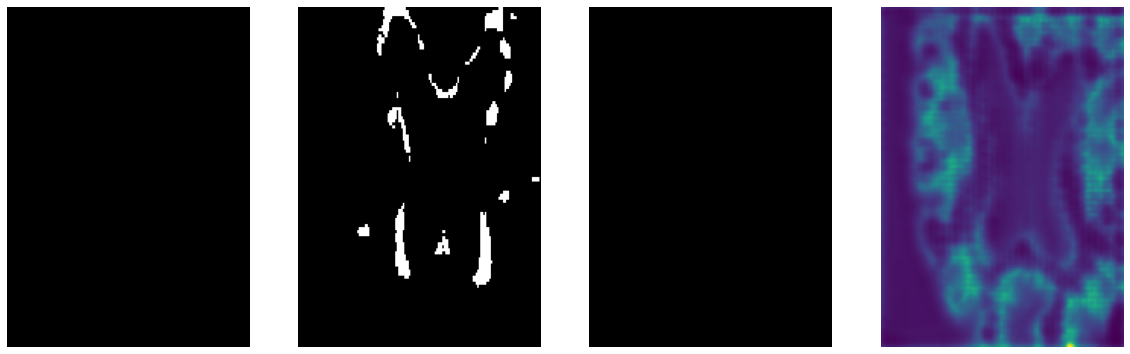

In [88]:
ind = 20
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind],cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(mean_p_hat.argmax(dim=1)[ind],cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(eus[ind].squeeze())
print(slice_dice(mean_p_hat[ind], y1[ind])); plt.axis('off')
plt.show()